In [36]:
import numpy as np
import pylab as plt
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional_recurrent import ConvLSTM1D
from keras.models import Sequential

In [37]:
history_size = 10
cdf_size = 100
kernel_size = 10

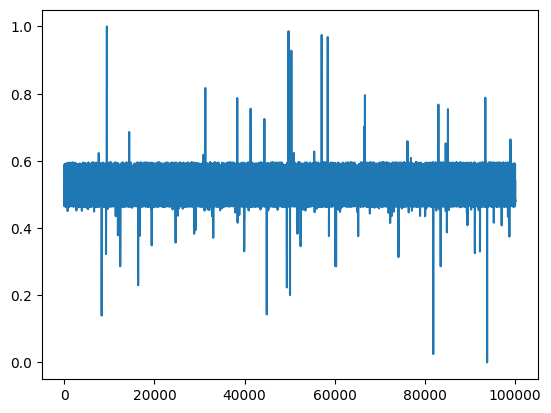

(1000, 100, 1)


In [38]:
# 数据加载，flatten，归一化，排序
from sklearn.preprocessing import MinMaxScaler
from src.experiment.common_utils import load_data, Distribution

# 数据加载
data_list = np.array([data[0] for data in load_data(Distribution.NYCT_10W, 1)]).reshape(-1, 1)
# 归一化
scaler = MinMaxScaler(feature_range=(0., 1.))
data_list = scaler.fit_transform(data_list)
plt.plot(list(range(len(data_list))), data_list)
plt.show()
# flatten
data_list = data_list.reshape(-1, cdf_size, 1)
# 排序
data_list = np.sort(data_list, axis=1)
print(data_list.shape)

In [39]:
# 生成训练数据
datas = [data_list[end_index - history_size: end_index] for end_index in
         range(history_size, len(data_list))]
datas = np.array(datas)
labels = [data_list[end_index] for end_index in
          range(history_size, len(data_list))]
labels = np.array(labels)
datas.shape, labels.shape

((990, 10, 100, 1), (990, 100, 1))

In [40]:
# filters: 卷积核数量
# kernel_size: 卷积核大小
# strides: 卷积核往右和往下移动的步长
# padding: 处理边界的策略，valid表示不处理边界，输出shape会变小；same表示处理边界，输出shape和输入shape一致
# return_sequences: 是否返回中间序列，true表示输出所有输出，false表示只输出最后一个时间的输出
seq = Sequential()
seq.add(ConvLSTM1D(filters=16, kernel_size=kernel_size, strides=1, activation='tanh',
                   input_shape=(None, cdf_size, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))

seq.add(ConvLSTM1D(filters=32, kernel_size=kernel_size, activation='tanh',
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))

seq.add(ConvLSTM1D(filters=32, kernel_size=kernel_size, activation='tanh',
                   padding='same', return_sequences=False))
seq.add(BatchNormalization())
seq.add(Dropout(0.5))

seq.add(Conv1D(filters=1, kernel_size=kernel_size, activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='nadam')
seq.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_16 (ConvLSTM1D)  (None, None, 100, 16)    10944     
                                                                 
 batch_normalization_13 (Bat  (None, None, 100, 16)    64        
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, None, 100, 16)     0         
                                                                 
 conv_lstm1d_17 (ConvLSTM1D)  (None, None, 100, 32)    61568     
                                                                 
 batch_normalization_14 (Bat  (None, None, 100, 32)    128       
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, None, 100, 32)    

Epoch 1/50
94/94 [==============================] - 17s 139ms/step - loss: 0.7774 - val_loss: 0.6960 - lr: 0.0010
Epoch 2/50
94/94 [==============================] - 15s 157ms/step - loss: 0.6926 - val_loss: 0.6930 - lr: 0.0010
Epoch 3/50
94/94 [==============================] - 14s 145ms/step - loss: 0.6925 - val_loss: 0.6928 - lr: 0.0010
Epoch 4/50
94/94 [==============================] - 13s 133ms/step - loss: 0.6924 - val_loss: 0.6927 - lr: 0.0010
Epoch 5/50
94/94 [==============================] - 13s 133ms/step - loss: 0.6924 - val_loss: 0.6926 - lr: 0.0010
Epoch 6/50
94/94 [==============================] - 13s 133ms/step - loss: 0.6924 - val_loss: 0.6925 - lr: 0.0010
Epoch 7/50
94/94 [==============================] - 12s 131ms/step - loss: 0.6923 - val_loss: 0.6924 - lr: 0.0010
Epoch 8/50
94/94 [==============================] - 12s 132ms/step - loss: 0.6923 - val_loss: 0.6923 - lr: 0.0010
Epoch 9/50
94/94 [==============================] - 12s 133ms/step - loss: 0.6923 - val_

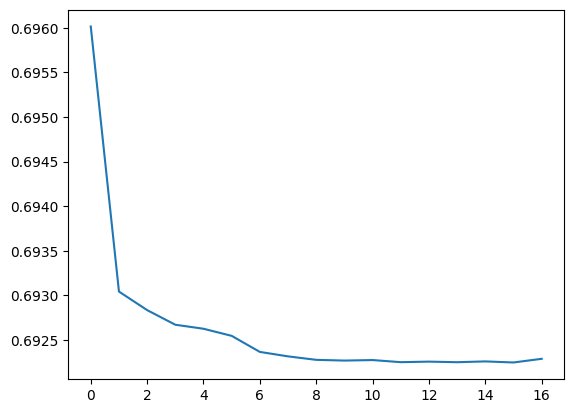

In [41]:
from keras.callbacks import ReduceLROnPlateau

# x为前1000个数据中每个数据的0-10个图片
# y为前1000个数据中每个数据的5-15个图片，因此预测5次，步长为10
# validation_split: 用于做验证集的数据百分比
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, mode='min', verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5)
history = seq.fit(datas, labels, batch_size=10, epochs=50, validation_split=0.05, callbacks=[early_stopping, reduce_lr],
                  verbose=1)
plt.plot(history.epoch, history.history['val_loss'])

In [42]:
# 生成预测数据
pred_data_list = data_list[len(data_list) - history_size:]
pred_data_list = np.array(pred_data_list).reshape(1, -1, 100, 1)
pred_data_list.shape

(1, 10, 100, 1)

In [43]:
# 预测
pred_output = seq.predict(pred_data_list)

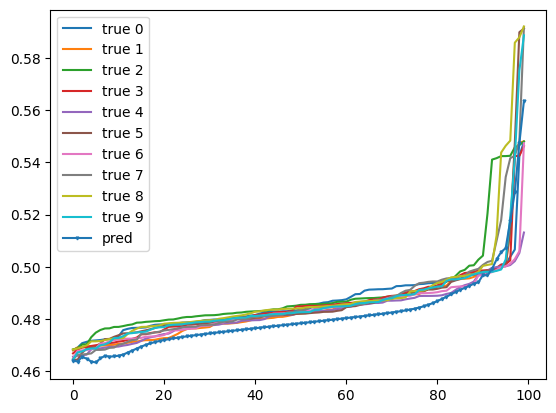

In [44]:
for i in range(history_size):
    plt.plot(pred_data_list[0, i].flatten(), label='true %d' % i)
plt.plot(pred_output[0].flatten(), label='pred', marker='v', markersize=2, color='#95CCBA')
plt.legend()

In [46]:
# TODO: NYCT数据有明显的离群值，需要过滤，当前来看的话CDF曲线没有明显的变化规律吗，导致LSTM预测效果差